# Empirical investigation of zombies

In [60]:
import requests
import bs4
import pandas
import os
import re
import networkx as nx
%matplotlib inline
import matplotlib.pyplot as plt
import itertools
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import string
plt.style.use('ggplot')

## Scrap data from ZMDB 
[ZMDB](http://www.zmdb.org/)

In [2]:
#get movies link
n = 243
links = []
if os.path.isfile("zombies-links.csv"):
    with open("zombies-links.csv","r") as f:
        links = f.readlines()
    links = [i.replace("\n","") for i in links]
else:  
    for i in range(0,n):
        url = "http://www.zmdb.org/list/?start="+str(i*30)
        data = bs4.BeautifulSoup(requests.get(url).content)
        for i in data.findAll("div",{"class":"cataloqueObjectText"}):
            links.append(i.a["href"])
    with open("zombies-links.csv","w") as f:
        for i in links:
            f.write(i+"\n")

In [3]:
#extract data from html page
def get_content(data):
    infos = {}
    try:
        infos["title"] = data.find("h1",{"itemprop":"name"}).contents[0].replace("(","").strip().lower()
    except:
        infos["title"] = "na"
    try:
        infos["year"] = re.findall('year=(.*?)\"',str(data))[0]
    except:
        infos["year"] = "na"
    try:
        infos["description"] = data.find("span",{"itemprop":"description"}).contents[0].lower()
    except:
        infos["description"] = "na"
    try:
        infos["zvalue"] = data.find("div",{"class":"zombometer"}).contents[1].split("/")[0].strip()
    except:
        infos["zvalue"] = "na"
    try:
        infos["keywords"] = [i.lower() for i in re.findall('kw=(.*?)\"',str(data))]
    except:
        infos["keywords"] = "na"
    try:
        infos["actors"] = [i.contents[1].replace(" ... ","").lower() for i in data.findAll("div",{"itemprop":"actor"})]
    except:
        infos["actors"] = "na"
    return infos

In [16]:
#Get data
corpus = []
if not os.path.exists("zombis-movies"):
    os.mkdir("zombis-movies")
for u in links:
    i = u.replace("/","-")
    if not os.path.isfile("zombis-movies/"+i):
        data = requests.get(u).content
        with open("zombis-movies/"+i,"w") as f:
            f.write(str(data))
    else:
        with open("zombis-movies/"+i,"r") as f:
            data = " ".join(f.readlines())        
    try:
        if "category: movie" in data:
            data = bs4.BeautifulSoup(data)
            data = get_content(data)
            corpus.append(data)
            #print(data["title"],data["year"],i)
    except:
        print(i)

In [55]:
#ad hoc cleaning data
def clean(d,year=False):   
    if year:
        try:
            a = int(d)
            if a<1900 or a >2016:
                a = 0
            return a
        except:
            return 0
    
    if type(d)==list:
        return [clean(u) for u in d]
    else:
        return d.replace("\n"," ").replace("%20"," ").replace("\\n","")

## Creating DataFrame of movies

In [56]:
zombis = pandas.DataFrame({"title":[clean(i["title"]) for i in corpus],"year":[clean(i["year"],True) for i in corpus],\
                  "description":[clean(i["description"]) for i in corpus],"zvalue":[i["zvalue"] for i in corpus],\
                 "keywords":[clean(i["keywords"]) for i in corpus]})

In [62]:
zombis[0:20]

,description,keywords,title,year,zvalue
0,"welcome to hell on earth, aka the soviet union...","[horror, ghosts, feature film, magic, anime, w...",first squad: the moment of truth,2009,5
1,the demon has been banished to earth. in order...,"[gore, horror, comedy, feature film, anthology]",tales of the supernatural,2014,2
2,things seem to be going well in japan until th...,"[horror, comedy, feature film, revenge, anime]",gyo: tokyo fish attack,2012,4
3,a group of people are opening a new haunted ho...,"[gore, splatter, horror, ghosts, demons, featu...",house of horrors: gates of hell,2015,4
4,"a young woman finds a computer, and several ta...","[horror, curse, feature film, anthology]",apparition of evil,2014,2
5,max is invovled with a beautiful young woman b...,"[gore, horror, comedy, feature film, relations...",burying the ex,2015,5
6,a university professor and his assistants work...,"[horror, resurrection, feature film, science, ...",lazarus effect,2015,4
7,"scott, a businessman, goes for a jog when some...","[gore, cannibalism, mummy, horror, comedy, fea...",razor\'s ring,2007,1
8,"those evil nazis come up with a new, desperate...","[horror, feature film, video game, nazi zombies]",reich of the dead,2015,5
9,the zombie apocalypse took place. a group of ...,"[horror, feature film, apocalypse, survival]",dead end,2011,5


## Temporal evolution

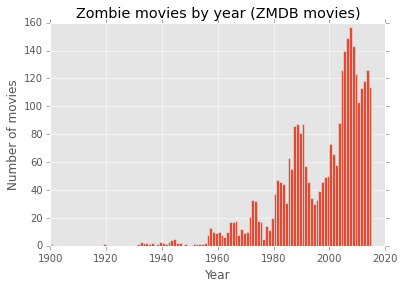

In [25]:
zombis[zombis["year"]>0]["year"].hist(bins=115)
plt.title("Zombie movies by year (ZMDB movies)")
plt.xlabel("Year")
plt.ylabel("Number of movies")

## Words from Titles

In [39]:
stop = stopwords.words('english')
porter_stemmer = PorterStemmer() #stemmer
words = []
for i in zombis.title:
    if i == "na":
        continue
    w = i.split(" ")
    w = [porter_stemmer.stem(i) for i in w if len(i)>2 and not i in stop]
    words += w
a = pandas.Series(words)
a.value_counts()[0:20]

dead       225
zombi      212
night       69
live        65
vampir      53
vs.         49
blood       47
ghost       46
dark        44
death       40
evil        40
mummi       36
hous        31
hell        31
curs        30
demon       30
terror      28
horror      26
return      25
monster     25
dtype: int64

## Words from description

In [61]:
stop = stopwords.words('english')
exclude = set(string.punctuation)
porter_stemmer = PorterStemmer() #stemmer
words = []
for i in zombis.description:
    if i == "na":
        continue
    w = ''.join(ch for ch in i if ch not in exclude).split(" ")
    w = [porter_stemmer.stem(i) for i in w if len(i)>2 and not i in stop]
    words += w
a = pandas.Series(words)
a.value_counts()[0:20]

zombi     3501
one       1215
get       1162
young     1052
woman     1038
peopl     1016
man        917
kill       885
group      811
dead       779
find       733
also       671
tri        661
end        655
turn       639
back       637
come       627
evil       533
must       527
surviv     472
dtype: int64

## Networks if titles words

In [ ]:
G = nx.Graph()
cnt = 0
stop = stopwords.words('english')

for i in zombis.title:
    cnt +=1
    if cnt%300 == 0:
        print(cnt)
    if i == "na":
        continue
    w = i.split(" ")
    w = [i for i in w if len(i)>2 and not i in stop]
    for j in w:
        if j in G.node:
            G.node[j]["weight"]+=1
        else:
            G.add_node(j,Label=j,weight=1)
    for j in itertools.combinations(w,2):
        if j in G.edges():
            G.edge[j[0]][j[1]]["weight"]+=1
        else:
            G.add_edge(j[0],j[1],weight=1)
nx.write_graphml(G,"zombies-titles.graphml")

In [ ]:
G = nx.Graph()
cnt = 0

for i in zombis.keywords:
    cnt +=1
    if cnt%300 == 0:
        print(cnt)
    if i == "na":
        continue
    for j in i:
        if j in G.node:
            G.node[j]["weight"]+=1
        else:
            G.add_node(j,Label=j,weight=1)
    for j in itertools.combinations(i,2):
        if j in G.edges():
            G.edge[j[0]][j[1]]["weight"]+=1
        else:
            G.add_edge(j[0],j[1],weight=1)
nx.write_graphml(G,"zombies-keywords.graphml")